# Imports


In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import traceback, warnings

warnings.filterwarnings("ignore", category=UserWarning)

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import cv2

from pynistview_utils import *


# Set up directories and files


In [3]:
# Configure input files

indir = "/Users/rmoraski/Documents/iCloud/School/Electrons/NISTView-ish/data/"
sempa_file_suffix = "sempa"

# name = "191001_Fe_whisker/Fe_whisker"

# name = "FeGd_Nov_Dec/171117_FeGd"
# runs = (2, 3)

name = "FeGd_Nov_Dec/FeGd100"
runs = (6, 7)
# runs = (11, 10)

# name = "FeGd_Nov_Dec/FeGd200"
# runs = (3, 2) # misaligned
# runs = (5, 6) # misaligned

# name = 'alice/171117_FeGd'
# runs = (2, 3)

# name = "FeGd_5x120/20161213"
# runs = (5, 6)
# runs = (8, 9)
# runs = (12, 13)

# name = "220719/FeGd3x"
# runs = (1, 2)
# runs = (3, 4)

# Specify the number of features - 1 in the image. This is used to segment and create masks.
segments = 2

# Specify gaussian denoising sigma
sigma = 2

# Specify non-local denoising strength h. Larger h -> more denoising.
h = 20

# Specify a scale for drawing the vector arrows. Smaller number -> longer arrow.
arrow_scale = 0.2

# Specify a color for the vector arrows.
# arrow_color = 'black'
arrow_color = "white"


# SEMPA files


In [4]:
image_dict = import_files(name, runs, indir)

intensity_1, intensity_1_blurred, intensity_1_flat = image_dict["i1"]
intensity_2, intensity_2_blurred, intensity_2_flat = image_dict["i2"]

m_1, axis_1, m_1_ydim, m_1_xdim, m_1_min, m_1_max = image_dict["m1"]
m_2, axis_2, m_2_ydim, m_2_xdim, m_2_min, m_2_max = image_dict["m2"]
m_3, axis_3, m_3_ydim, m_3_xdim, m_3_min, m_3_max = image_dict["m3"]
m_4, axis_4, m_4_ydim, m_4_xdim, m_4_min, m_4_max = image_dict["m4"]

scale = image_dict["scale"]
magnification = image_dict["magnification"]

print(f"Scale: {scale:0.2e}, magnification: {magnification}")


Searching FeGd_Nov_Dec/FeGd100* for runs (6, 7)...
Found files:
['FeGd100006_ix.sempa', 'FeGd100006_iy.sempa', 'FeGd100006_mx.sempa', 'FeGd100006_my.sempa', 'FeGd100007_ix2.sempa', 'FeGd100007_iz.sempa', 'FeGd100007_mx2.sempa', 'FeGd100007_mz.sempa']
Scale: 9.05e-09, magnification: 60000.0


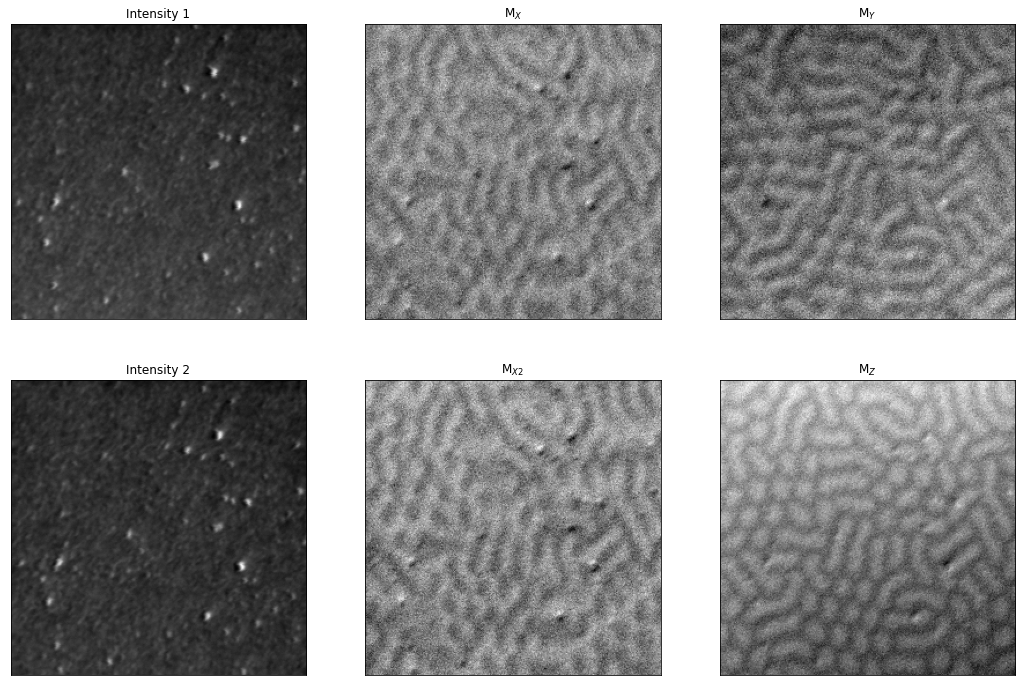

In [5]:
fig = plt.figure(figsize=(18, 12))
plt.subplot(231)
plt.imshow(intensity_1, cmap="gray")
plt.title("Intensity 1")
plt.subplot(232)
plt.imshow(m_1, cmap="gray")
plt.title(rf"M$_{axis_1}$")
plt.subplot(233)
plt.imshow(m_2, cmap="gray")
plt.title(f"M$_{axis_2}$")
plt.subplot(234)
plt.imshow(intensity_2, cmap="gray")
plt.title("Intensity 2")
plt.subplot(235)
plt.imshow(m_4, cmap="gray")
plt.title(f"M$_{axis_4}$$_2$")
plt.subplot(236)
plt.imshow(m_3, cmap="gray")
plt.title(f"M$_{axis_3}$")

for ax in fig.get_axes():
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)


# LTEM files


In [6]:
# ltem_data_name = 'img005_alpha05.npy'
# ltem_data_name = 'img006_alpha05_OL0000.npy'
# ltem_data_name = '00_B.npy'
# ltem_data_name = 'n50_B.npy'
ltem_data_name = "inductions2.npz"
ltem_data_path = indir + "will/" + ltem_data_name

ltem_phases, ltem_magnitudes, ltem_circular_contours, ltem_contours_g, ltem_xerror, ltem_yerror = process_ltem_data(
    ltem_data_path
)
print(f"Found {len(ltem_circular_contours)} circular contours out of {len(ltem_contours_g)} total contours")
ltem_boxes = get_bounding_boxes(ltem_circular_contours)
ltem_box_widths = np.asarray(ltem_boxes)[:, 2] if len(ltem_circular_contours) > 0 else []


Found 161 circular contours out of 398 total contours


# Align scans

Get the 2 ix images aligned as best possible


Found 126 matches; keeping 18.
Top left: [11 13], Top right: [255  12]
Bottom left: [  0 255], Bottom right: [255 255]
Cropping (11, 13) to (255, 255)


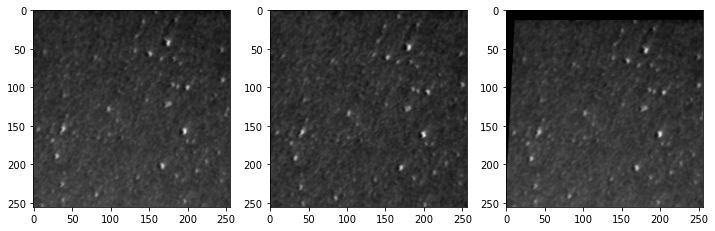

In [7]:
try:
    results_r, results_h, h, imMatches, imKeypoints = align_and_scale(
        intensity_1, intensity_2, m_1, m_2, m_3, m_4, match_percent=0.15, filter=0
    )
    intensity_1_r, intensity_2_r, m_1_r, m_2_r, m_3_r, m_4_r = results_r

    m_1_r_g_full = rescale_to(gaussian_filter(m_1_r, sigma), m_1_r)
    m_2_r_g_full = rescale_to(gaussian_filter(m_2_r, sigma), m_2_r)
    m_3_r_g_full = rescale_to(gaussian_filter(m_3_r, sigma), m_3_r)

    # Eliminate outliers
    m_1_r_g, m_2_r_g, m_3_r_g = limit_to(m_1_r_g_full), limit_to(m_2_r_g_full), limit_to(m_3_r_g_full)


except Exception as ex:
    print()
    print(ex)
    print()
    traceback.print_exc()


In [8]:
looks_good = input("Does that look well aligned?") or "Yes"


In [9]:
# If that doesn't work well...
if looks_good != "Yes":
    print("Keeping the full images")
    m_1_r_g_full = rescale_to(gaussian_filter(m_1, sigma), m_1)
    m_2_r_g_full = rescale_to(gaussian_filter(m_2, sigma), m_2)
    m_3_r_g_full = rescale_to(gaussian_filter(m_3, sigma), m_3)

    # Eliminate outliers
    m_1_r_g, m_2_r_g, m_3_r_g = limit_to(m_1_r_g_full), limit_to(m_2_r_g_full), limit_to(m_3_r_g_full)


# Find offsets

The imaging components do not use the same zero point. Since the magnetization vector should have the same magnitude over the entire sample, minimize the min to max spread across the combined images.


In [10]:
m_1_adjusted, m_2_adjusted, m_3_adjusted = adjust_magnetization_ranges(
    m_1_r_g, m_2_r_g, m_3_r_g, axis_1, axis_2, axis_3
)


MX average: 0.0687, MY average: -0.5054, MZ average: 0.0756
MX offset: 0.0583, MY offset: -0.0460, MZ offset: -0.0896
MX original range: 1.1983 to 1.3357; offset range: 0.140, -0.0689 to 0.0713
MY original range: -0.5795 to -0.4314; offset range: 0.131, -0.0715 to 0.0600
MZ original range: -0.0573 to 0.2085; offset range: 0.143, -0.0712 to 0.0719


# Calculate magnitudes and angles, find contours


In [11]:
# Calculate magnitudes and angles
magnitudes = get_magnitudes(m_1_adjusted, m_2_adjusted, m_3_adjusted)
magnitudes /= magnitudes.max()
max_dev = np.std(magnitudes)

phis, thetas = get_phases(m_1_adjusted, m_2_adjusted, m_3_adjusted)
phis_rgba = render_phases_and_magnitudes(phis, magnitudes)

# Apply a light gaussian filter to clean up the images
magnitudes_flattened = rescale_to(gaussian_filter(magnitudes, 2), [0, 1])
phis_flattened = rescale_to(gaussian_filter(phis, 3), phis)
thetas_flattened = rescale_to(gaussian_filter(thetas, 3), thetas)
phis_flattened_rgba = render_phases_and_magnitudes(phis_flattened, magnitudes_flattened)

# Find circular features in the Z direction
circular_contours, contours_g, contours = find_circular_contours(thetas_flattened)

mag_low, mag_high = np.percentile(magnitudes_flattened, 5), np.percentile(magnitudes_flattened, 95)

# Calculate 2D values as well
magnitudes_2d = get_magnitudes(m_1_adjusted, m_2_adjusted)
magnitudes_2d /= magnitudes_2d.max()
max_dev_2d = np.std(magnitudes_2d)
upper_limit = magnitudes_2d.mean() + 3 * max_dev_2d
magnitudes_2d_trimmed = np.where(magnitudes_2d < upper_limit, magnitudes_2d, upper_limit)
magnitudes_2d_flattened = rescale_to(gaussian_filter(magnitudes_2d_trimmed, 3), [0, 1])

phis_2d, _ = get_phases(m_1_adjusted, m_2_adjusted)

print(
    "Magnitudes range from {:.4f} to {:.4f} with mean {:.4f}, stddev {:.4f}, and 90% confidence interval {:.4f}..{:.4f}".format(
        magnitudes_flattened.min(), magnitudes_flattened.max(), magnitudes_flattened.mean(), max_dev, mag_low, mag_high
    )
)
print(f"\N{greek small letter phi} ranges from {phis_flattened.min():.4f} to {phis_flattened.max():.4f}")
print(f"\N{greek small letter theta} ranges from {thetas_flattened.min():.4f} to {thetas_flattened.max():.4f}")
print(
    f"Found {len(circular_contours)} circular contours, {len(contours_g)} contours not on the edge, out of {len(contours)} total."
)


Magnitudes range from 0.0000 to 1.0000 with mean 0.2940, stddev 0.0908, and 90% confidence interval 0.1477..0.4611
φ ranges from 0.0001 to 6.2827
θ ranges from 0.0040 to 3.1279
Found 31 circular contours, 68 contours not on the edge, out of 73 total.


# Magnitude and phase sanity checks


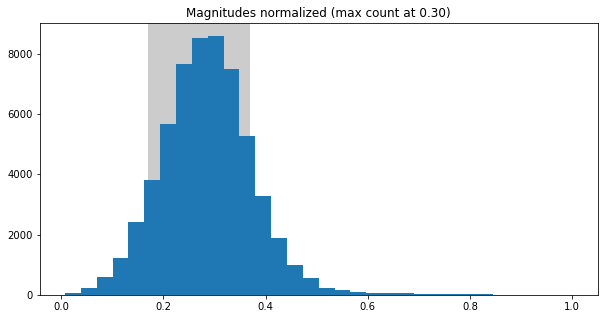

In [12]:
show_magnitude_distribution(magnitudes)


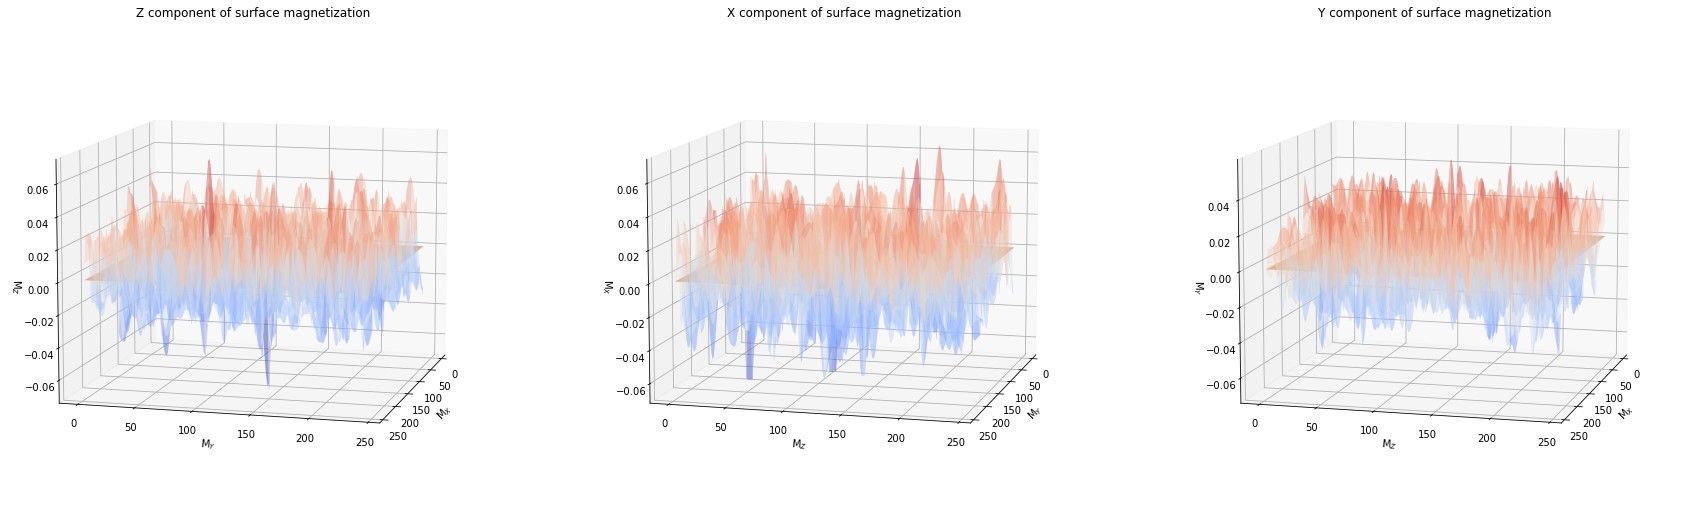

In [13]:
show_magnetization_components(magnitudes, m_1_adjusted, m_2_adjusted, m_3_adjusted, axis_1, axis_2, axis_3)


# SEMPA feature plots


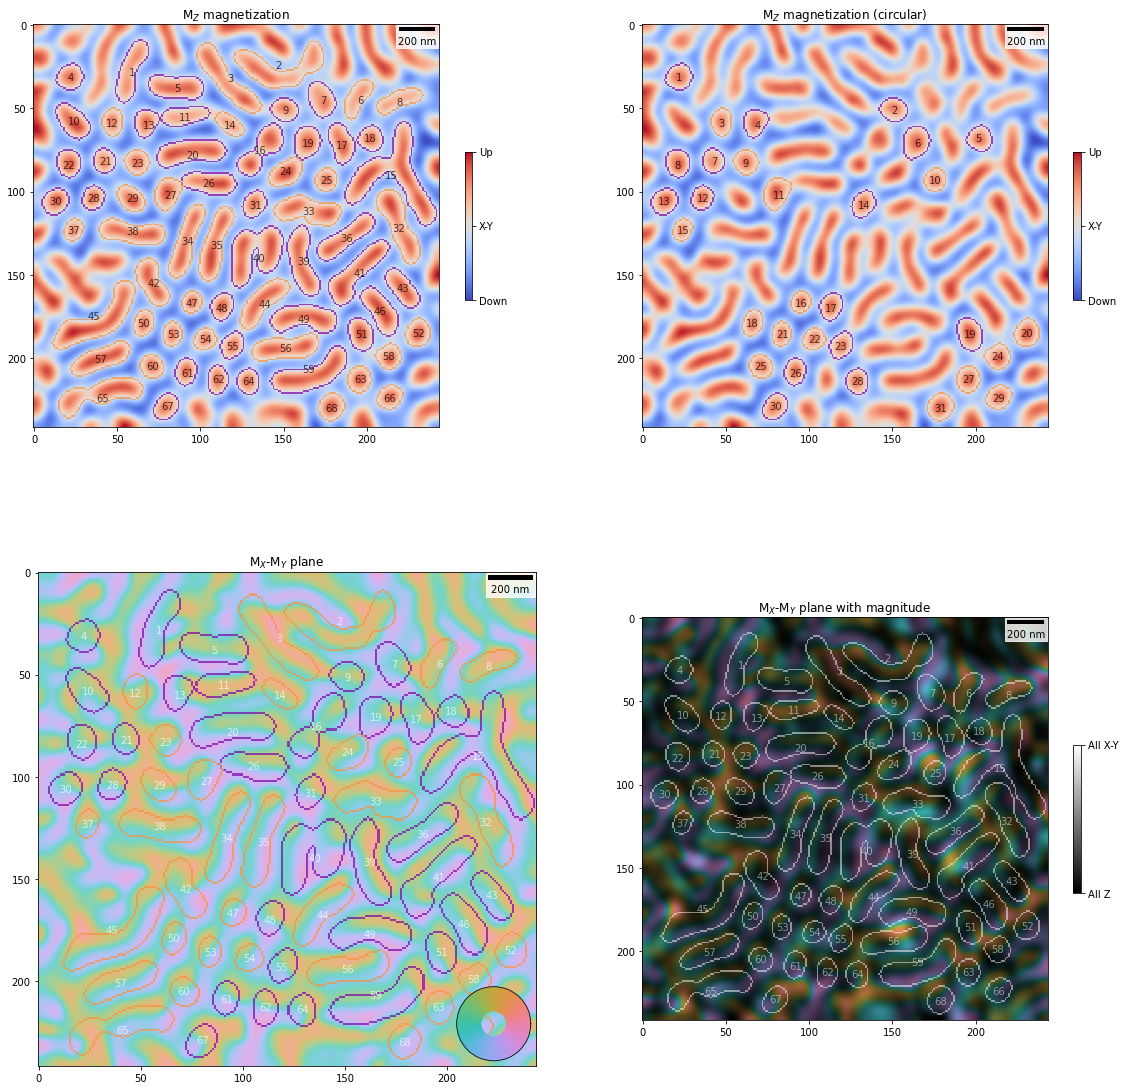

In [14]:
show_contours_overview(
    thetas_flattened,
    phis_flattened,
    contours_g,
    circular_contours,
    magnitudes_2d_flattened,
    axis_1,
    axis_2,
    axis_3,
    scale,
)


Found 31 boxes.
Found 15 clockwise and 15 anticlockwise contours
Of 31 circular feature(s) total, 11 have deviations ≤ π/6 (0.52)
Indices are [10, 13, 14, 15, 16, 17, 18, 20, 21, 25, 26]
Index 10 has the lowest α deviation with α = 2.46, σ = 0.38, MAE = 0.30, sem = 0.06, n = 1.07
Index 16 has the closest winding number with α = 2.71, σ = 0.41, MAE = 0.33, sem = 0.07, n = 0.99


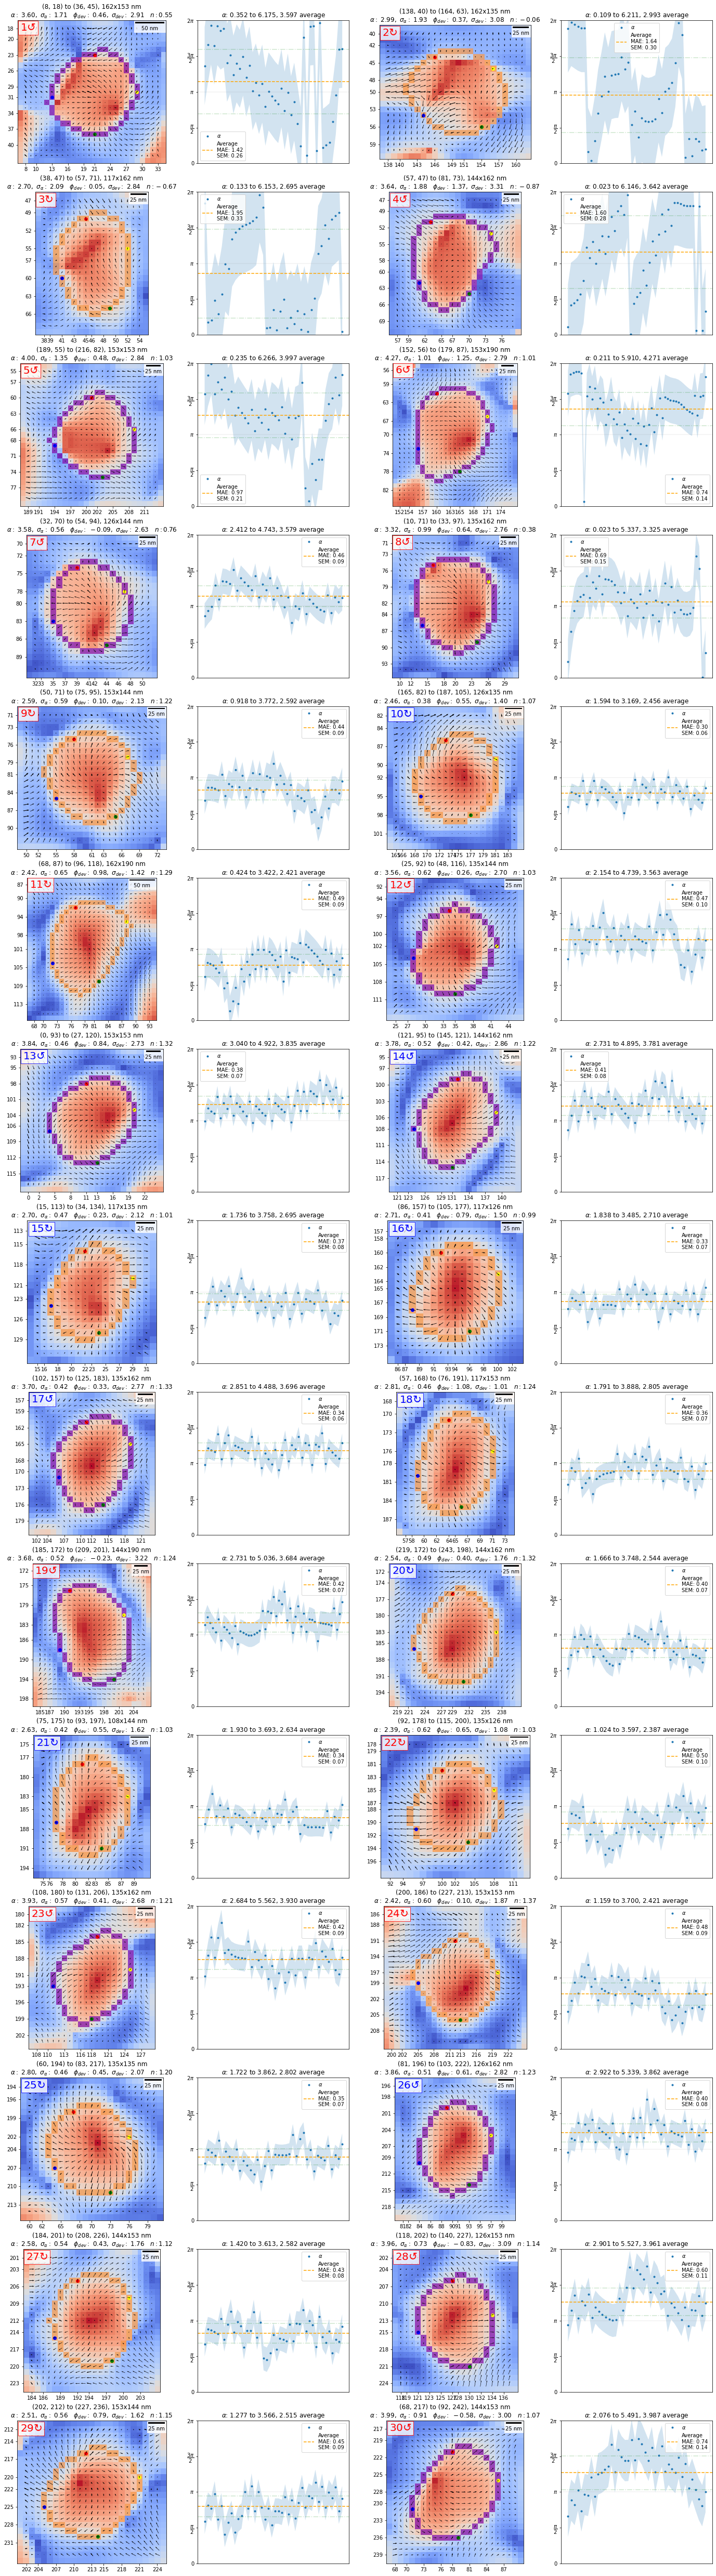

In [15]:
candidates, all_contours = show_circles(
    magnitudes_flattened,
    phis,
    thetas,
    circular_contours,
    scale,
    m_1_adjusted,
    m_2_adjusted,
    m_3_adjusted,
    phis_m=phis_flattened_rgba,
    normalize=False,
    show="thetas",
    show_numbers=True,
    show_axes=True,
    show_title=True,
    just_candidates=False,
    show_anyway=True,
)

# dev_avg, dev_std, alpha_avg, alpha_std, mae, sem, width_nm, height_nm, winding_number
error = scale * 1e9 / 2

indices = list(candidates.keys())
candidate_values = np.array(list(candidates.values()))
alphas_candidates = [c[2] for c in candidate_values]
alphas_all = [c[2] for c in list(all_contours.values())]

std_candidates = [c[3] for c in candidate_values]
mae_candidates = [c[4] for c in candidate_values]
sem_candidates = [c[5] for c in candidate_values]
winding_n_candidates = [c[8] for c in candidate_values]
winding_n_all = [c[8] for c in np.array(list(all_contours.values()))]

sizes = [(c[6], c[7]) for c in candidate_values]
widths, heights = zip(*sizes) if sizes else ([], [])

print(
    f"Of {len(circular_contours)} circular feature(s) total, {len(indices)} have deviations ≤ \N{greek small letter pi}/6 ({np.pi / 6:.2f})"
)

if len(indices) > 0:
    print(f"Indices are {indices}")
    best_alpha_index = np.argmin(candidate_values[:, 3])
    best_winding_value = min(candidate_values[:, 8], key=lambda x: abs(x - 1))
    best_winding_index = np.where(candidate_values[:, 8] == best_winding_value)[0][0]
    print(
        f"Index {list(candidates.keys())[best_alpha_index]} has the lowest \N{greek small letter alpha} deviation with \N{greek small letter alpha} = "
        f"{alphas_candidates[best_alpha_index]:.2f}, \N{greek small letter sigma} = {std_candidates[best_alpha_index]:.2f}, "
        f"MAE = {mae_candidates[best_alpha_index]:.2f}, "
        f"sem = {sem_candidates[best_alpha_index]:.2f}, n = {winding_n_candidates[best_alpha_index]:.2f}"
    )
    print(
        f"Index {list(candidates.keys())[best_winding_index]} has the closest winding number with \N{greek small letter alpha} = "
        f"{alphas_candidates[best_winding_index]:.2f}, \N{greek small letter sigma} = {std_candidates[best_winding_index]:.2f}, "
        f"MAE = {mae_candidates[best_winding_index]:.2f}, "
        f"sem = {sem_candidates[best_winding_index]:.2f}, n = {winding_n_candidates[best_winding_index]:.2f}"
    )


4 groups:
[[1, 4, 5, 9], [2, 3, 6, 7, 8, 10, 11, 12, 14], [15, 16, 17, 20, 21, 22, 24, 25, 27, 29], [18, 19, 23, 26, 28, 30]]

2 loners:
[[0], [13]]


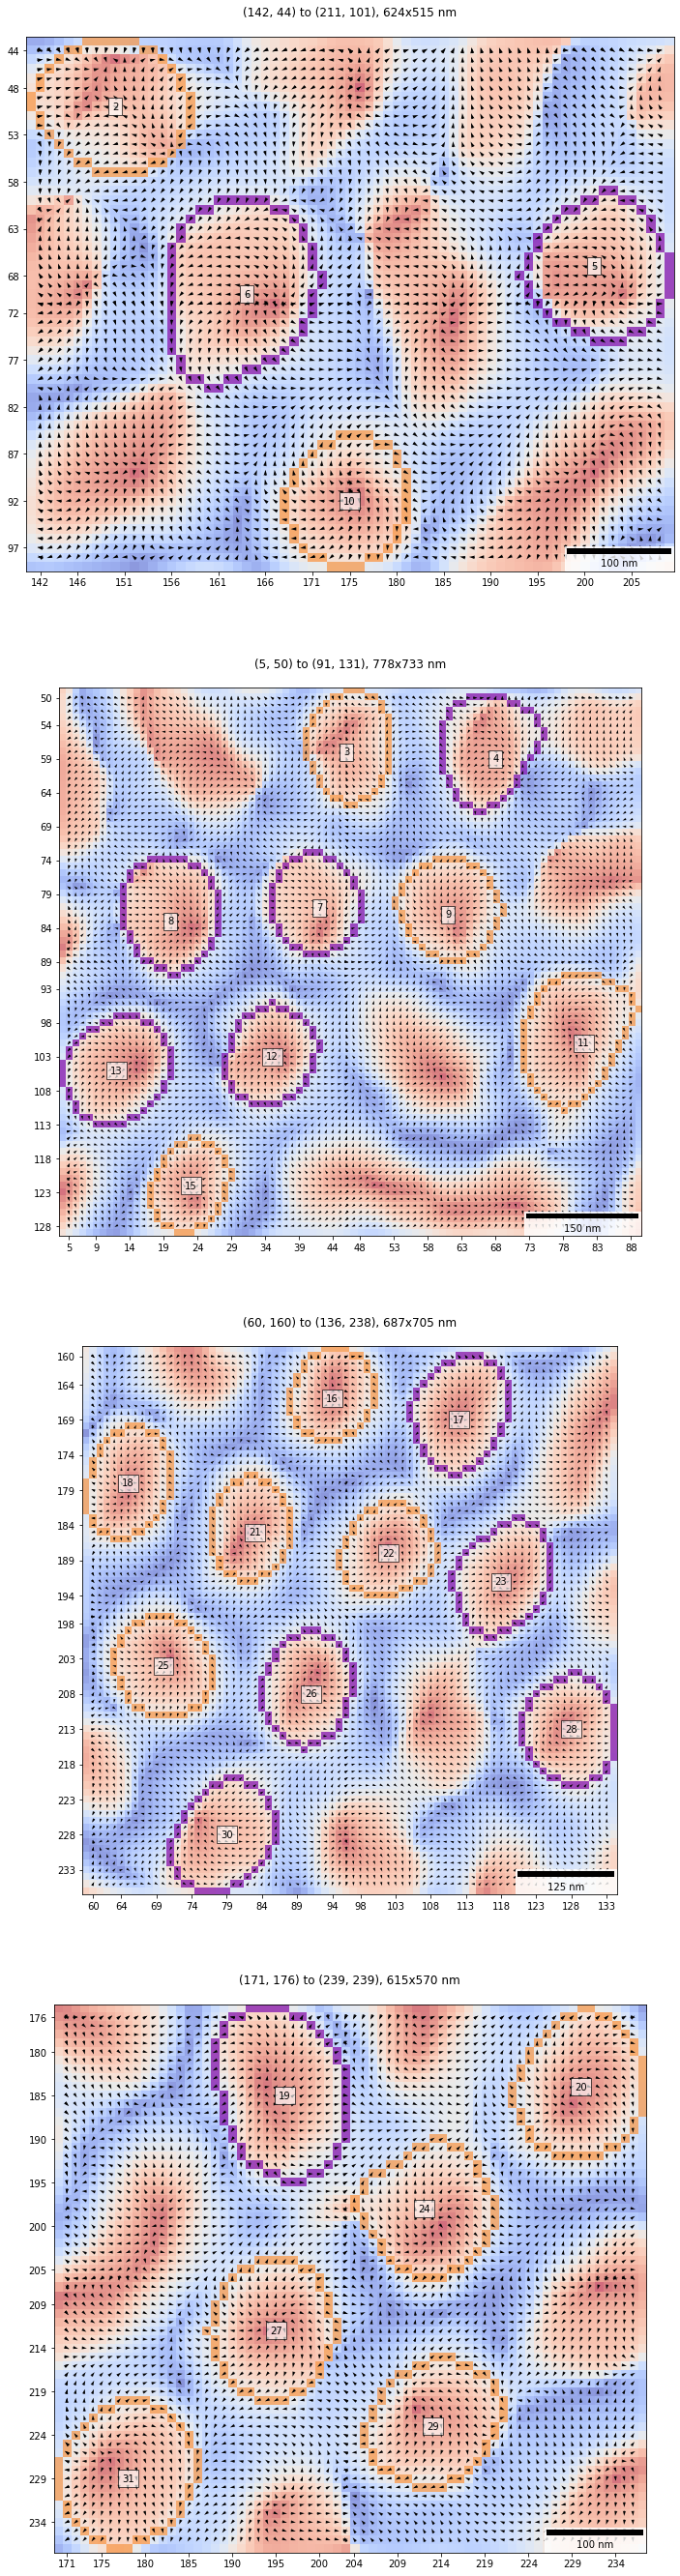

In [16]:
show_groups(circular_contours, magnitudes, phis, thetas, scale)


# LTEM plots


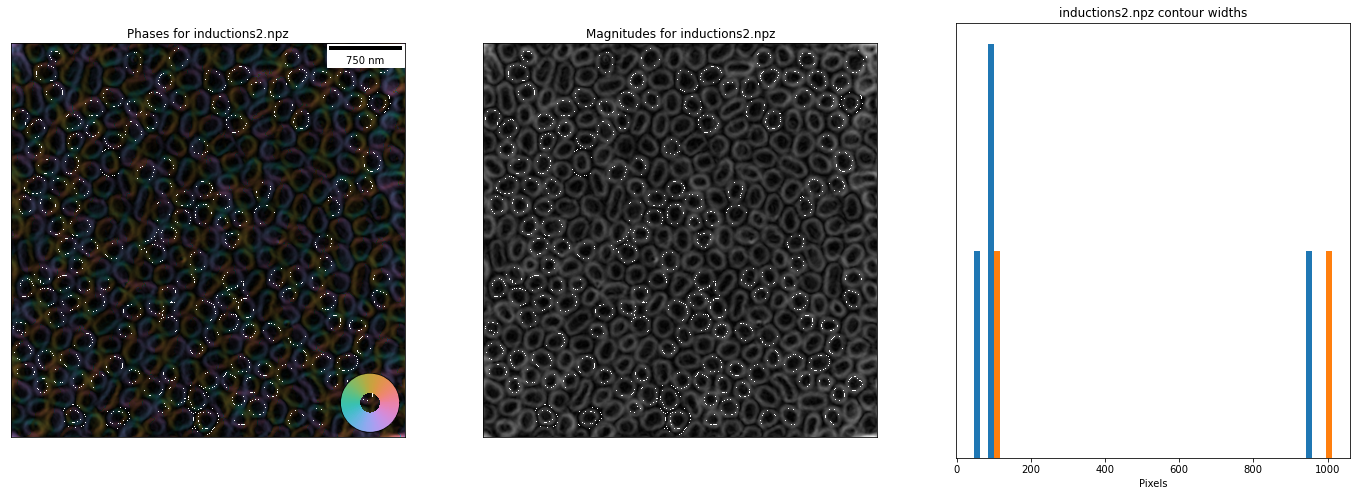

In [17]:
show_ltem_data(
    ltem_magnitudes,
    ltem_phases,
    ltem_circular_contours,
    ltem_box_widths,
    ltem_xerror,
    ltem_yerror,
    ltem_data_name,
    use_cutoff=False,
)


In [18]:
ltem_candidates, ltem_all_contours = show_circles(
    ltem_magnitudes,
    ltem_phases,
    ltem_phases,
    ltem_circular_contours,
    ltem_xerror,
    normalize=False,
    show="phis",
    show_numbers=True,
    show_axes=True,
    show_title=True,
    just_candidates=False,
    origin="lower",
    show_limit=300,
    skip_plot=True,
)

ltem_indices = list(ltem_candidates.keys())
ltem_candidate_values = np.array(list(ltem_candidates.values()))
ltem_alphas_candidates = [c[2] for c in ltem_candidate_values]

ltem_sizes = [(c[6], c[7]) for c in ltem_candidate_values]
ltem_widths, ltem_heights = zip(*ltem_sizes)

print(
    f"Of {len(ltem_circular_contours)} circular feature(s) total, {len(ltem_indices)} have deviations ≤ \N{greek small letter pi}/6 ({np.pi / 6:.2f})"
)


Found 161 boxes.
Found 60 clockwise and 62 anticlockwise contours (39 spurious contours)
Of 161 circular feature(s) total, 112 have deviations ≤ π/6 (0.52)


# Alpha

Deviation from domain wall normal traveling from low $\mathrm{M_z}$ to high $\mathrm{M_z}$. Alpha ranges from 0 to $2\pi$.


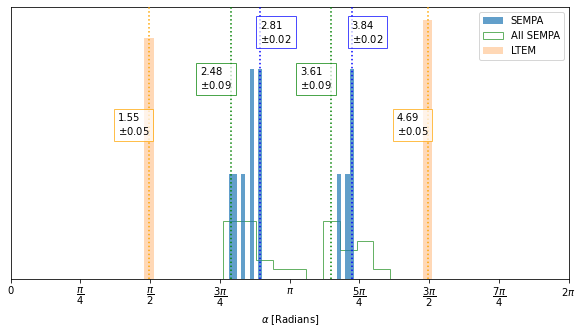

In [19]:
show_alphas_2(alphas_candidates, alphas_all, ltem_alphas_candidates, show_all=True)


# Winding number

$n=\frac{1}{4\pi}\int{\vec{M}\cdot \left(\frac{d\vec{M}}{dx}\times\frac{d\vec{M}}{dy}\right)}\ dxdy$


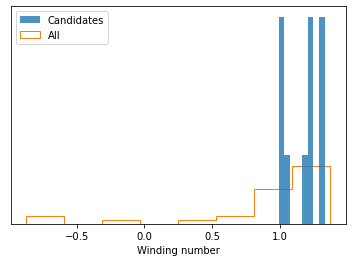

In [20]:
show_winding_numbers(winding_n_candidates, winding_n_all)


# Feature sizes


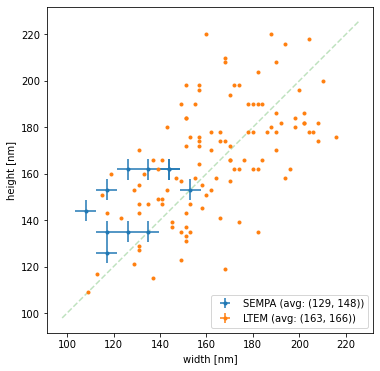

In [21]:
show_contour_sizes(widths, heights, error, error, ltem_widths, ltem_heights, ltem_xerror, ltem_yerror)
